In [1]:
%run ../base_setup.ipynb

Foundation: 2.09.024
Transition: 2.09.022
Engines   : 2.03.015
Behavioral: 2.04.016


-------------------------
## Build the raw synthetic file

In [2]:
builder = SyntheticBuilder.from_env('temporal_risk_score')

In [3]:
tools = builder.intent_model

In [4]:
builder.pm.reset_intents()
builder.pm_persist()

In [5]:
# get the columns from the Risk-Score
df = builder.intent_model.model_columns(connector_name=builder.CONNECTOR_SOURCE, headers=['member_id', 'flu_risk_score', 'flu_shot', 'state', 'latent_has_children', 'age'], column_name='member_reference')
builder.add_column_description(column_name='member_reference', description="The distribution from the flu-risk score base")

In [6]:
sample_size = df.shape[0]

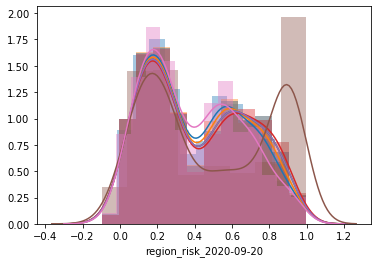

In [7]:
# Temporal risk around region
ny_risk = [0.05, 0.075, 0.1, 0.12, 0.1, 0.5, 0]
ca_risk = [0, 0, 0, 0.05, 0.075, 0.1, 1.2]

for day in range(7):
    date_header = f"region_risk_2020-09-{14+day}"
    # NY Risk
    selection = [tools.select2dict(column='state', condition="=='New York'"),
                 tools.select2dict(column='flu_risk_score', condition="<0.8", logic='AND'),
                 tools.select2dict(column='flu_shot', condition="==0", logic='AND')]
    action = tools.action2dict(method='correlate_numbers', header='flu_risk_score', offset=ny_risk[day])
    default = tools.action2dict(method='@header', header='flu_risk_score')
    df[date_header] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name=date_header, intent_order=0)
    
    # California Risk
    selection = [tools.select2dict(column='state', condition="=='California'"),
                 tools.select2dict(column=date_header, condition="<0.8", logic='AND'),
                 tools.select2dict(column='flu_shot', condition="==0", logic='AND')]
    action = tools.action2dict(method='correlate_numbers', header=date_header, offset=ny_risk[day])
    default = tools.action2dict(method='@header', header=date_header)
    df[date_header] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name=date_header, intent_order=1)
    
    # adjust to be in bounds of the range
    selection = [tools.select2dict(column=date_header, condition=">=1")]
    action = tools.action2dict(method='get_bounded_normal', mean=0.9, std=0.02, lower=0.8, upper=0.998)
    default = tools.action2dict(method='@header', header=date_header)
    df[date_header] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name=date_header, intent_order=2)
    
    builder.add_column_description(column_name=date_header, description=f"Day {day} of the regional risk in NY and CA")
    
    sns.distplot(df[date_header])

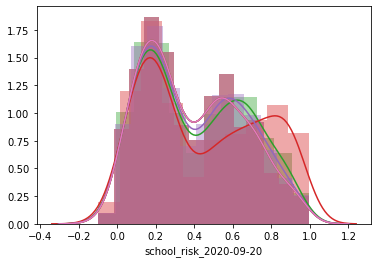

In [8]:
# temporal risk of returning to school
school_risk = [0, 0, 0.1, 0.3, 0.05, 0, 0]

for day in range(7):
    date_header = f"school_risk_2020-09-{14+day}"
    # add return on Wednesday
    selection = [tools.select2dict(column='latent_has_children', condition="==1"),
                 tools.select2dict(column='flu_risk_score', condition="<0.8", logic='AND'),
                 tools.select2dict(column='flu_shot', condition="==0", logic='AND')]
    action = tools.action2dict(method='correlate_numbers', header='flu_risk_score', offset=school_risk[day])
    default = tools.action2dict(method='@header', header='flu_risk_score')
    df[date_header] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name=date_header, intent_order=0)
    
    # adjust to be in bounds of the range
    selection = [tools.select2dict(column=date_header, condition=">=1")]
    action = tools.action2dict(method='get_bounded_normal', mean=0.9, std=0.02, lower=0.8, upper=0.998)
    default = tools.action2dict(method='@header', header=date_header)
    df[date_header] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name=date_header, intent_order=1)
    
    builder.add_column_description(column_name=date_header, description=f"Day {day} of the Return the School on the Wednesday of the week")
    
    sns.distplot(df[date_header])

In [9]:
builder.run_synthetic_pipeline(size=sample_size)

In [10]:
builder.report_column_catalog()

,column_name,description
0,member_reference,The distribution from the flu-risk score base
1,region_risk_2020-09-14,Day 0 of the regional risk in NY and CA
2,region_risk_2020-09-15,Day 1 of the regional risk in NY and CA
3,region_risk_2020-09-16,Day 2 of the regional risk in NY and CA
4,region_risk_2020-09-17,Day 3 of the regional risk in NY and CA
5,region_risk_2020-09-18,Day 4 of the regional risk in NY and CA
6,region_risk_2020-09-19,Day 5 of the regional risk in NY and CA
7,region_risk_2020-09-20,Day 6 of the regional risk in NY and CA
8,school_risk_2020-09-14,Day 0 of the Return the School on the Wednesday of the week
9,school_risk_2020-09-15,Day 1 of the Return the School on the Wednesday of the week


In [11]:
builder.report_intent()

,order,intent,parameters,creator
level,,,,
member_reference,0,model_columns,"[connector_name='primary_source', headers=['member_id', 'flu_risk_score', 'flu_shot', 'state', 'latent_has_children', 'age'], column_name='member_reference']",doatridge
region_risk_2020-09-14,0,correlate_selection,"[selection=[{'column': 'state', 'condition': ""=='New York'""}, {'column': 'flu_risk_score', 'condition': '<0.8', 'logic': 'AND'}, {'column': 'flu_shot', 'condition': '==0', 'logic': 'AND'}], action...",doatridge
,1,correlate_selection,"[selection=[{'column': 'state', 'condition': ""=='California'""}, {'column': 'region_risk_2020-09-14', 'condition': '<0.8', 'logic': 'AND'}, {'column': 'flu_shot', 'condition': '==0', 'logic': 'AND'...",doatridge
,2,correlate_selection,"[selection=[{'column': 'region_risk_2020-09-14', 'condition': '>=1'}], action={'method': 'get_bounded_normal', 'mean': 0.9, 'std': 0.02, 'lower': 0.8, 'upper': 0.998}, default_action={'method': '@...",doatridge
region_risk_2020-09-15,0,correlate_selection,"[selection=[{'column': 'state', 'condition': ""=='New York'""}, {'column': 'flu_risk_score', 'condition': '<0.8', 'logic': 'AND'}, {'column': 'flu_shot', 'condition': '==0', 'logic': 'AND'}], action...",doatridge
,1,correlate_selection,"[selection=[{'column': 'state', 'condition': ""=='California'""}, {'column': 'region_risk_2020-09-15', 'condition': '<0.8', 'logic': 'AND'}, {'column': 'flu_shot', 'condition': '==0', 'logic': 'AND'...",doatridge
,2,correlate_selection,"[selection=[{'column': 'region_risk_2020-09-15', 'condition': '>=1'}], action={'method': 'get_bounded_normal', 'mean': 0.9, 'std': 0.02, 'lower': 0.8, 'upper': 0.998}, default_action={'method': '@...",doatridge
region_risk_2020-09-16,0,correlate_selection,"[selection=[{'column': 'state', 'condition': ""=='New York'""}, {'column': 'flu_risk_score', 'condition': '<0.8', 'logic': 'AND'}, {'column': 'flu_shot', 'condition': '==0', 'logic': 'AND'}], action...",doatridge
,1,correlate_selection,"[selection=[{'column': 'state', 'condition': ""=='California'""}, {'column': 'region_risk_2020-09-16', 'condition': '<0.8', 'logic': 'AND'}, {'column': 'flu_shot', 'condition': '==0', 'logic': 'AND'...",doatridge


-------------------------
## Region Risk Transition

In [12]:
tr_region = Transition.from_env('region_risk_score')

In [13]:
tr_region.pm.reset_intents()
tr_region.pm_persist()

In [14]:
df = tr_region.load_source_canonical()

In [15]:
df = tr_region.intent_model.auto_clean_header(df)
df = tr_region.intent_model.auto_transition(df)
df = tr_region.intent_model.to_remove(df, regex=['flu_risk_score', 'flu_shot', 'state', 'latent_has_children', 'age', 'school_risk_'])


In [16]:
tr_region.canonical_report(df)

,Attributes (8),dType,%_Null,%_Dom,Count,Unique,Observations
0,member_id,int64,0.0%,0.1%,1000,1000,"max=99977261 | min=10034108 | mean=56845317.84 | dominant=[10034108, 10170540]"
1,region_risk_2020-09-14,float64,0.0%,0.7%,1000,597,max=0.997 | min=-0.097 | mean=0.4 | dominant=0.221
2,region_risk_2020-09-15,float64,0.0%,0.7%,1000,610,max=0.997 | min=-0.097 | mean=0.41 | dominant=0.221
3,region_risk_2020-09-16,float64,0.0%,0.7%,1000,604,max=0.997 | min=-0.097 | mean=0.42 | dominant=0.221
4,region_risk_2020-09-17,float64,0.0%,0.7%,1000,611,max=0.997 | min=-0.097 | mean=0.42 | dominant=0.221
5,region_risk_2020-09-18,float64,0.0%,0.7%,1000,604,max=0.997 | min=-0.097 | mean=0.42 | dominant=0.221
6,region_risk_2020-09-19,float64,0.0%,0.9%,1000,568,max=0.998 | min=-0.097 | mean=0.49 | dominant=0.905
7,region_risk_2020-09-20,float64,0.0%,0.8%,1000,601,max=0.997 | min=-0.097 | mean=0.39 | dominant=0.221


In [17]:
tr_region.run_transition_pipeline()

-------------------------
## School Risk Transition

In [18]:
tr_school = Transition.from_env('school_risk_score')

In [19]:
tr_school.pm.reset_intents()
tr_school.pm_persist()

In [20]:
df = tr_school.load_source_canonical()

In [21]:
df = tr_school.intent_model.auto_clean_header(df)
df = tr_school.intent_model.auto_transition(df)
df = tr_school.intent_model.to_remove(df, regex=['flu_risk_score', 'flu_shot', 'state', 'latent_has_children', 'age', 'region_risk_'])


In [22]:
tr_school.canonical_report(df)

,Attributes (8),dType,%_Null,%_Dom,Count,Unique,Observations
0,member_id,int64,0.0%,0.1%,1000,1000,"max=99977261 | min=10034108 | mean=56845317.84 | dominant=[10034108, 10170540]"
1,school_risk_2020-09-14,float64,0.0%,0.8%,1000,601,max=0.997 | min=-0.097 | mean=0.39 | dominant=0.221
2,school_risk_2020-09-15,float64,0.0%,0.8%,1000,601,max=0.997 | min=-0.097 | mean=0.39 | dominant=0.221
3,school_risk_2020-09-16,float64,0.0%,0.7%,1000,612,max=0.997 | min=-0.097 | mean=0.41 | dominant=0.221
4,school_risk_2020-09-17,float64,0.0%,0.7%,1000,619,max=0.998 | min=-0.097 | mean=0.45 | dominant=0.221
5,school_risk_2020-09-18,float64,0.0%,0.7%,1000,612,max=0.997 | min=-0.097 | mean=0.4 | dominant=0.221
6,school_risk_2020-09-19,float64,0.0%,0.8%,1000,601,max=0.997 | min=-0.097 | mean=0.39 | dominant=0.221
7,school_risk_2020-09-20,float64,0.0%,0.8%,1000,601,max=0.997 | min=-0.097 | mean=0.39 | dominant=0.221


In [23]:
tr_school.run_transition_pipeline()